# Projekt "Przewidywana długość życia" -  RAPORT 

AUTORZY:

Patrycja Szczepaniak, 286668

Anna Pręgowska, 262892

## Wstęp

Dane, które wykorzystamy zostały już obrobione w poprzedniej części projektu (analizie eksploracyjnej). Z danych został również usunięty atrybut BMI ze względu na nieujednolicone wartości.

Zdecydowałyśmy się na wykorzystanie metody regularyzacji Ridge podczas regresji, ponieważ posiadamy względnie mało atrybutów, które mogłyby mieć wpływ na końcowy wynik. Naszą decyzj poparło sprawdzenie, że RMSE jest najmniejszy dla metody Ridge.

### Import danych

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [213]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, roc_curve
from math import sqrt, log

In [214]:
data_file = pd.read_excel('processed_data.xlsx')
data = pd.DataFrame(data_file)
data.describe()

Year  Life expectancy  Adult Mortality  infant deaths  \
count  2517.000000      2517.000000      2517.000000    2517.000000   
mean   2007.510926        69.460375       161.253973      31.210568   
std       4.612614         9.539968       124.212020     125.888329   
min    2000.000000        36.300000         1.000000       0.000000   
25%    2004.000000        63.300000        71.000000       0.000000   
50%    2008.000000        72.300000       138.000000       2.000000   
75%    2012.000000        75.900000       224.000000      20.000000   
max    2015.000000        89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B        Measles  \
count  2517.000000             2517.000000  2517.000000    2517.000000   
mean      4.561830              859.965320    78.657780    2359.658721   
std       4.035270             2123.365708    24.404182   11037.605828   
min       0.010000                0.000000     2.000000       0.000000   
25%       0.830000               21.928139    73.000000       0.000000   
50%       3.810000              110.677971    87.000000      15.000000   
75%       7.588667              561.916864    96.000000     362.000000   
max      17.870000            19479.911610    99.000000  212183.000000   

               BMI  under-five deaths  ...     HIV/AIDS            GDP  \
count  2517.000000        2517.000000  ...  2517.000000    2517.000000   
mean     38.431608          43.407231  ...     1.656218    7443.275923   
std      20.008002         171.171055  ...     4.613008   14201.496420   
min       1.400000           0.000000  ...     0.100000       1.681350   
25%      19.300000           0.000000  ...     0.100000     462.517913   
50%      43.900000           3.000000  ...     0.100000    1771.586620   
75%      56.300000          25.000000  ...     0.800000    5895.401636   
max      87.300000        2500.000000  ...    43.500000  119172.741800   

         Population  thinness 10-19 years  thinness 5-9 years  \
count  2.517000e+03           2517.000000         2517.000000   
mean   3.672773e+07              4.847708            4.885470   
std    1.434717e+08              4.464975            4.554679   
min    1.082100e+04              0.100000            0.100000   
25%    2.141669e+06              1.600000            1.600000   
50%    7.874835e+06              3.300000            3.300000   
75%    2.174397e+07              7.100000            7.200000   
max    1.371220e+09             27.700000           28.600000   

       Income composition of resources    Schooling  fertility rate 1960  \
count                      2517.000000  2517.000000          2517.000000   
mean                          0.632446    12.087376             5.527760   
std                           0.211552     3.359298             1.779913   
min                           0.000000     0.000000             1.940000   
25%                           0.489000    10.100000             3.866000   
50%                           0.685000    12.400000             6.275000   
75%                           0.787000    14.400000             6.896000   
max                           0.948000    20.700000             8.187000   

       suicide rate 1985-2016  Death rate 1960  
count             2517.000000      2517.000000  
mean               116.787058        16.097751  
std                360.980609         7.479614  
min                  0.032738         0.000000  
25%                 12.195652         9.800000  
50%                 14.153521        14.731000  
75%                111.939815        21.772000  
max               3678.901961        36.838000  

[8 rows x 23 columns]

#### Histogram dzietności 1960 - przerdstawienie nowej cechy

In [215]:
atr = 'fertility rate 1960'
plt.figure(figsize=(10,7), dpi= 80)
for c in data.Continent.unique():
    sns.distplot(data.loc[data.Continent == c, atr], label=c)
plt.legend();

##### Wnioski

Ogólnie najmniejsza dzietność była w Europie. Dla pozostałych kontynentów jest porównywana, aczkplwiek wybija się trochę Afryka - ma najmniejszy rozrzut wartości.

### Wybór cech

Stworzenie dodatkowych wskaźników.

In [216]:
data['child_immunization_index'] = (data['Polio'] * data['Diphtheria'] * data['Hepatitis B'])/100 
data['child_life_conditions_index'] = data['Schooling'] / (1 + data['thinness 5-9 years'] * data['Alcohol'])
data['country_development_index'] = data['Schooling'] * data['Income composition of resources'] * data['Total expenditure'] 
data['thinness_square'] = data['thinness 5-9 years'] * data['thinness 5-9 years']

Bierzemy wszystkie atrybuty oprócz 'Life expectancy', tych mocno skorelowanych oraz tych klasyfkujących na kontynent i kraj.

In [217]:
features = list(data.columns)

for i in ["Life expectancy", "Continent", "Country", "infant deaths", "thinness 10-19 years", "percentage expenditure", "Income composition of resources"]:
    features.remove(i) 

features

['Year',
 'Status',
 'Adult Mortality',
 'Alcohol',
 'Hepatitis B',
 'Measles',
 'BMI',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness 5-9 years',
 'Schooling',
 'fertility rate 1960',
 'suicide rate 1985-2016',
 'Death rate 1960',
 'child_immunization_index',
 'child_life_conditions_index',
 'country_development_index',
 'thinness_square']

#### Mapowanie wartości status na wartości {0, 1}.

In [218]:
mapped_values = list()
mapped_data = data.copy()
for col in ['Status']:
    values_of_col = mapped_data[col].unique()
    mapped = dict(zip(values_of_col, range(len(values_of_col))))
    mapped_values.append(mapped)
    mapped_data = mapped_data.applymap(lambda s: mapped.get(s) if s in mapped else s)
    
X = mapped_data[features]
y = mapped_data["Life expectancy"]

#### Stworzenie listy parametrów regularyzacji alpha.

In [219]:
alp = 1
alphas= []
alphas.append(alp)
while alp > 0.001:
    alp = (alp - 0.001)
    alphas.append(alp)

alphas = alphas[::-1]

### Stworzenie modelu regresji z regularyzacją Ridge

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [221]:
model_all = linear_model.Ridge(normalize=True)
grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : alphas}], scoring='neg_mean_squared_error', 
                             return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
best_model_all = grid_search.best_estimator_

predicted_all = best_model_all.predict(X_test)

print("RMSE = {}".format(sqrt(mean_squared_error(y_test, predicted_all))))


RMSE = 3.386770841723656


#### Parametr alpha najlepszego estymatora.

In [222]:
alpha = best_model_all.alpha
alpha

0.001999999999999119

#### Obliczenie RMSE dla danych testowych i uczących oraz wykreślenie zależności.

In [223]:
cv = grid_search.cv_results_

rmse_test = [sqrt(-score) for score in cv["mean_test_score"]]
rmse_train = [sqrt(-score) for score in cv["mean_train_score"]]

In [224]:
plt.figure(dpi=150)
plt.plot(alphas, rmse_test, color="blue", label="Błąd dla danych testowych")
plt.plot(alphas, rmse_train, color="red", label="Błąd dla danych uczących")
plt.title("Zależność wysokości RMSE od współczynnika regularyzacji")
plt.legend()

##### Wnioski

Dla małych wartości alpha osiagamy najmniejszy pierwiastek błędu średniokwadratowego. Wartość współczynnika, dla którego RMSE powinno być najmniejsze, leży w minimum funkcji.

Spośród testowanych alpha, najmniejszą wartość RMSE osiągnęłyśmy dla 0,01999999999999913.


#### Funkcja pomocnicza licząca współczynniki regularyzacji.

In [225]:
def choose_coefs(model, title="", want_desc=False):
    chosen_ =  {} 
    sorted_ = []

    for param, coef in zip(features, model.coef_):
        chosen_[coef] = param

    sorted_ = sorted(chosen_.keys(), key=abs, reverse = True)

    plt.figure(dpi=150)
    plt.bar([chosen_[key] for key in sorted_], sorted_, color="red")
    plt.ylim(-7, 17)
    plt.grid()
    plt.title(title)
    plt.xticks(rotation=90)
    
    if want_desc:
        for key in sorted_:
            print("cecha: ", chosen_[key], "\n\tma wartość : ", round(key, 5))
            

#### Wartości współczynników dla modelu

cecha:  Status 
	ma wartość :  1.78817
cecha:  thinness 5-9 years 
	ma wartość :  -0.61431
cecha:  Schooling 
	ma wartość :  0.61396
cecha:  HIV/AIDS 
	ma wartość :  -0.52188
cecha:  Death rate 1960 
	ma wartość :  -0.35014
cecha:  Total expenditure 
	ma wartość :  -0.33678
cecha:  fertility rate 1960 
	ma wartość :  0.24849
cecha:  Alcohol 
	ma wartość :  -0.24216
cecha:  child_life_conditions_index 
	ma wartość :  -0.20695
cecha:  Year 
	ma wartość :  0.06185
cecha:  country_development_index 
	ma wartość :  0.03708
cecha:  thinness_square 
	ma wartość :  0.03674
cecha:  Diphtheria 
	ma wartość :  0.02884
cecha:  BMI 
	ma wartość :  0.02547
cecha:  Polio 
	ma wartość :  0.01649
cecha:  Adult Mortality 
	ma wartość :  -0.01342
cecha:  under-five deaths 
	ma wartość :  -0.01171
cecha:  Hepatitis B 
	ma wartość :  -0.00726
cecha:  suicide rate 1985-2016 
	ma wartość :  -0.00073
cecha:  GDP 
	ma wartość :  5e-05
cecha:  child_immunization_index 
	ma wartość :  -4e-05
cecha:  Measles 
	ma

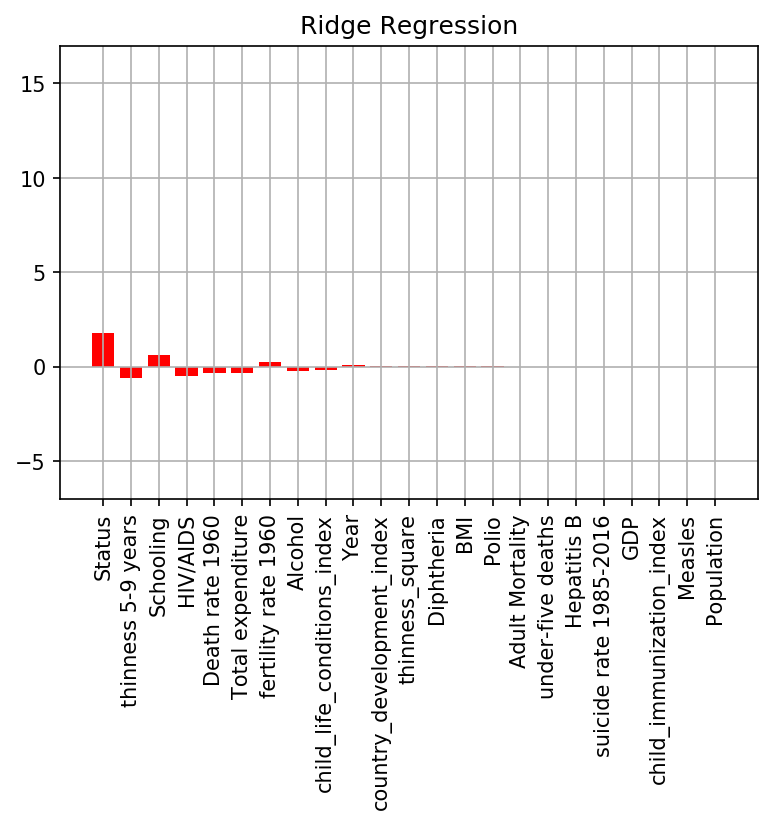

In [226]:
choose_coefs(best_model_all, title="Ridge Regression", want_desc=True)

##### Wnioski

Najwyższe wartości bezwzględne współczynników są dla atrybutów Status, Schooling oraz HIV/AIDS i to one mają nawiększy wpływ na oszacowane wartości. Ujemna wartość HIV/AIDS spowodowana jest negatywną korelacją z atrybutem wyjściowym. 

Atrybuty,  których słupki nie są widoczne na wykresie, mają znikomy wpływ na  wynik.


In [227]:

alp = 200
big_alphas= []
big_alphas.append(alp)
while alp > 1:
    alp = (alp - 1)
    big_alphas.append(alp)

big_alphas = big_alphas[::-1]

Text(0.5, 1.0, 'Wykres współczynników dla Ridge')

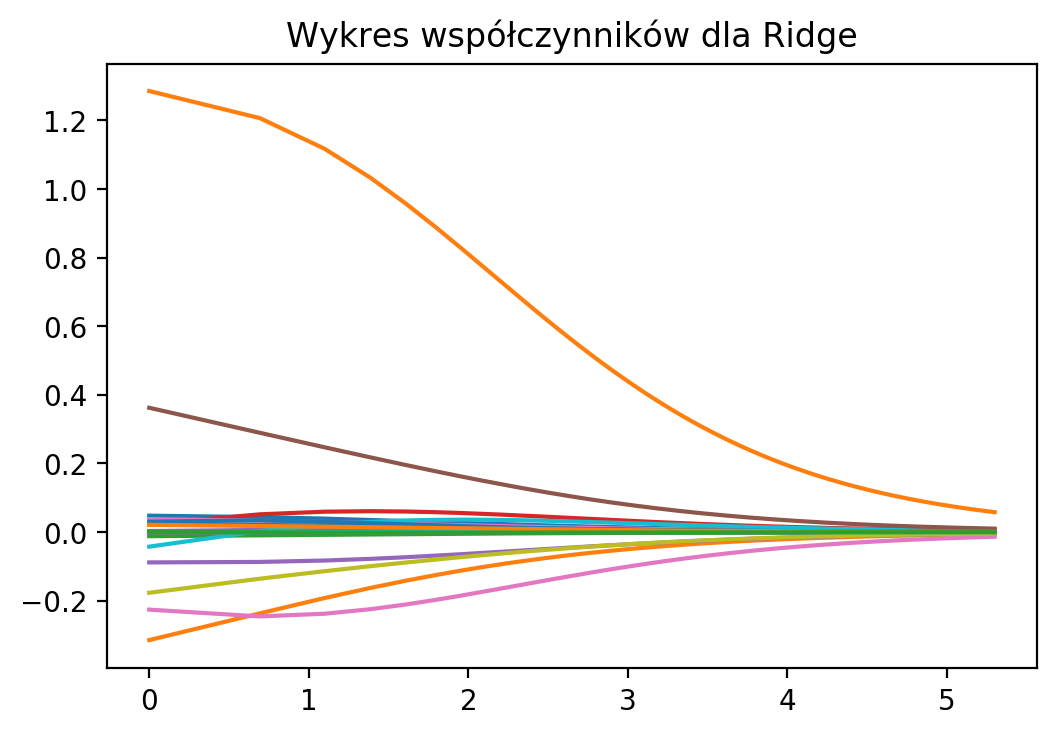

In [228]:
coefs=[]
for a in big_alphas:
    model_all = linear_model.Ridge(alpha=a, normalize=True)
    
    model_all.fit(X_train, y_train)
    coefs.append(model_all.coef_)
    

plt.figure(dpi=200)
plt.plot([log(a) for a in big_alphas], coefs)
plt.title("Wykres współczynników dla Ridge")


### Model Lasso 

In [180]:
model_all = linear_model.Lasso(normalize=True)
grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : alphas}], scoring='neg_mean_squared_error', 
                             return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
best_model_all = grid_search.best_estimator_

predicted_all = best_model_all.predict(X_test)

print("RMSE dla Lasso = {}".format(sqrt(mean_squared_error(y_test, predicted_all))))

RMSE dla Lasso = 3.377743837035273


In [181]:
alpha = best_model_all.alpha
alpha

0.0009999999999991188

In [182]:
cv = grid_search.cv_results_

rmse_test = [sqrt(-score) for score in cv["mean_test_score"]]
rmse_train = [sqrt(-score) for score in cv["mean_train_score"]]

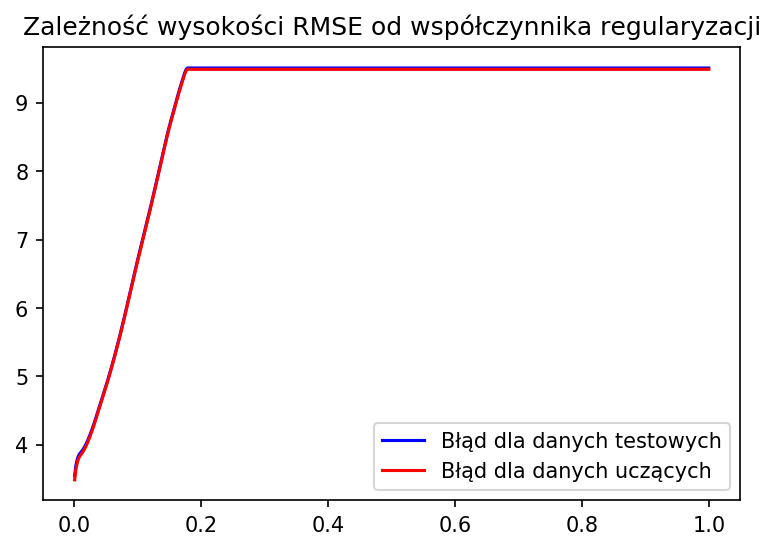

In [183]:
plt.figure(dpi=150)
plt.plot(alphas, rmse_test, color="blue", label="Błąd dla danych testowych")
plt.plot(alphas, rmse_train, color="red", label="Błąd dla danych uczących")
plt.title("Zależność wysokości RMSE od współczynnika regularyzacji")
plt.legend()

cecha:  Status 
	ma wartość :  1.48459
cecha:  Schooling 
	ma wartość :  0.63648
cecha:  HIV/AIDS 
	ma wartość :  -0.52036
cecha:  thinness 5-9 years 
	ma wartość :  -0.37707
cecha:  Death rate 1960 
	ma wartość :  -0.34817
cecha:  Total expenditure 
	ma wartość :  -0.21865
cecha:  Alcohol 
	ma wartość :  -0.19579
cecha:  child_life_conditions_index 
	ma wartość :  -0.13371
cecha:  fertility rate 1960 
	ma wartość :  0.09555
cecha:  Year 
	ma wartość :  0.0435
cecha:  country_development_index 
	ma wartość :  0.02971
cecha:  Diphtheria 
	ma wartość :  0.02617
cecha:  BMI 
	ma wartość :  0.02565
cecha:  thinness_square 
	ma wartość :  0.02387
cecha:  Adult Mortality 
	ma wartość :  -0.0141
cecha:  Polio 
	ma wartość :  0.01312
cecha:  under-five deaths 
	ma wartość :  -0.00889
cecha:  Hepatitis B 
	ma wartość :  -0.00476
cecha:  suicide rate 1985-2016 
	ma wartość :  -0.00062
cecha:  GDP 
	ma wartość :  5e-05
cecha:  Measles 
	ma wartość :  -2e-05
cecha:  Population 
	ma wartość :  0.0


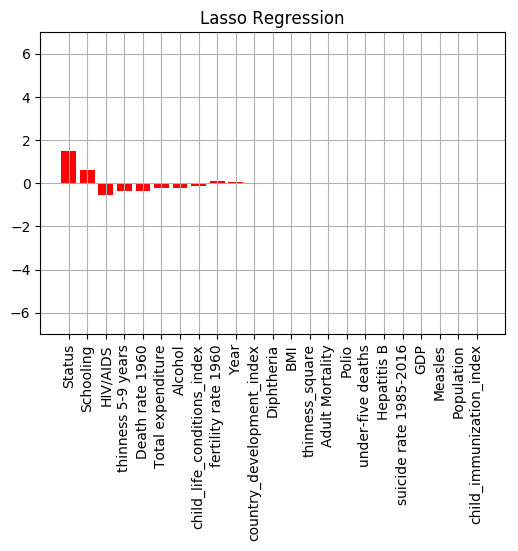

In [184]:
choose_coefs(best_model_all, title="Lasso Regression", want_desc=True)

### Model Elastic Net

In [185]:
model_all = linear_model.ElasticNet(normalize=True)
grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : alphas}], scoring='neg_mean_squared_error', 
                             return_train_score=True, cv=5)
grid_search.fit(X_train, y_train)
best_model_all = grid_search.best_estimator_

predicted_all = best_model_all.predict(X_test)

print("RMSE dla ElasticNet = {}".format(sqrt(mean_squared_error(y_test, predicted_all))))

RMSE dla ElasticNet = 4.290215059037332


In [186]:
alpha = best_model_all.alpha
alpha

0.0009999999999991188

In [187]:
cv = grid_search.cv_results_

rmse_test = [sqrt(-score) for score in cv["mean_test_score"]]
rmse_train = [sqrt(-score) for score in cv["mean_train_score"]]

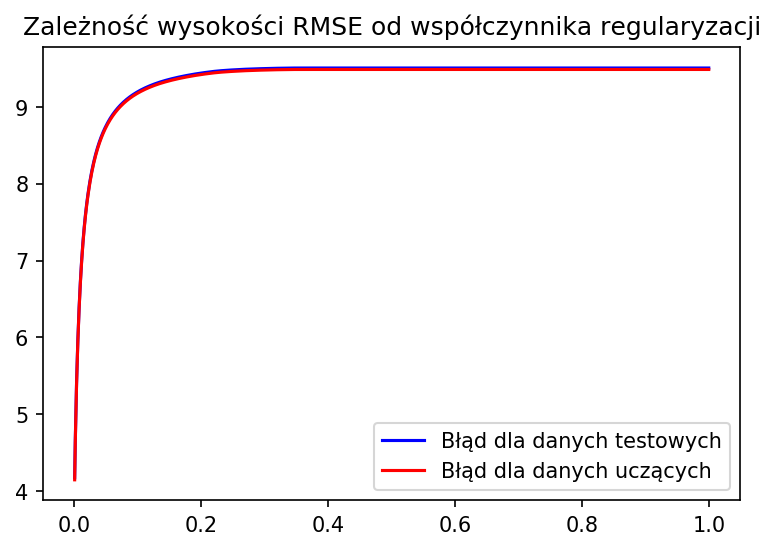

In [188]:
plt.figure(dpi=150)
plt.plot(alphas, rmse_test, color="blue", label="Błąd dla danych testowych")
plt.plot(alphas, rmse_train, color="red", label="Błąd dla danych uczących")
plt.title("Zależność wysokości RMSE od współczynnika regularyzacji")
plt.legend()

cecha:  Status 
	ma wartość :  1.27486
cecha:  Schooling 
	ma wartość :  0.3624
cecha:  HIV/AIDS 
	ma wartość :  -0.31299
cecha:  fertility rate 1960 
	ma wartość :  -0.22315
cecha:  Death rate 1960 
	ma wartość :  -0.176
cecha:  thinness 5-9 years 
	ma wartość :  -0.08551
cecha:  Year 
	ma wartość :  0.04615
cecha:  BMI 
	ma wartość :  0.03747
cecha:  Total expenditure 
	ma wartość :  -0.03434
cecha:  child_life_conditions_index 
	ma wartość :  0.02718
cecha:  Diphtheria 
	ma wartość :  0.023
cecha:  Polio 
	ma wartość :  0.02147
cecha:  country_development_index 
	ma wartość :  0.02093
cecha:  Alcohol 
	ma wartość :  0.02093
cecha:  Adult Mortality 
	ma wartość :  -0.01179
cecha:  Hepatitis B 
	ma wartość :  0.00307
cecha:  under-five deaths 
	ma wartość :  -0.00116
cecha:  thinness_square 
	ma wartość :  0.00039
cecha:  child_immunization_index 
	ma wartość :  0.00013
cecha:  GDP 
	ma wartość :  4e-05
cecha:  Measles 
	ma wartość :  -2e-05
cecha:  Population 
	ma wartość :  0.0
cech

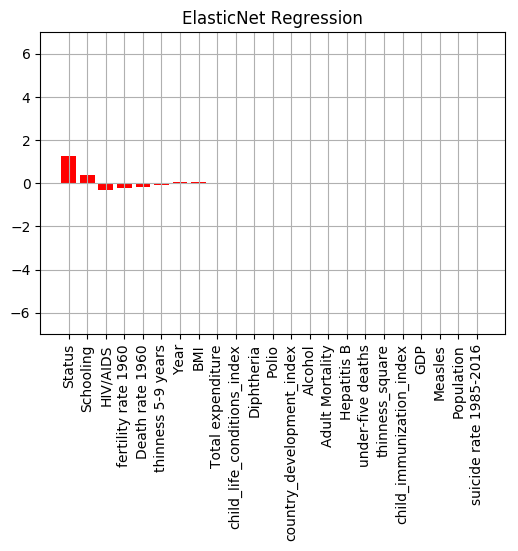

In [189]:
choose_coefs(best_model_all, title="ElasticNet Regression", want_desc=True)

### Modele dla poszczególnych kontynentów dla Ridge

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Asia - RMSE= 2.29902050557473
Europe - RMSE= 2.5079964556938643


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Africa - RMSE= 3.1693503173028024


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


North America - RMSE= 3.762240424988572


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


South America - RMSE= 1.3849640714418754


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Oceania - RMSE= 1.7934615398833629


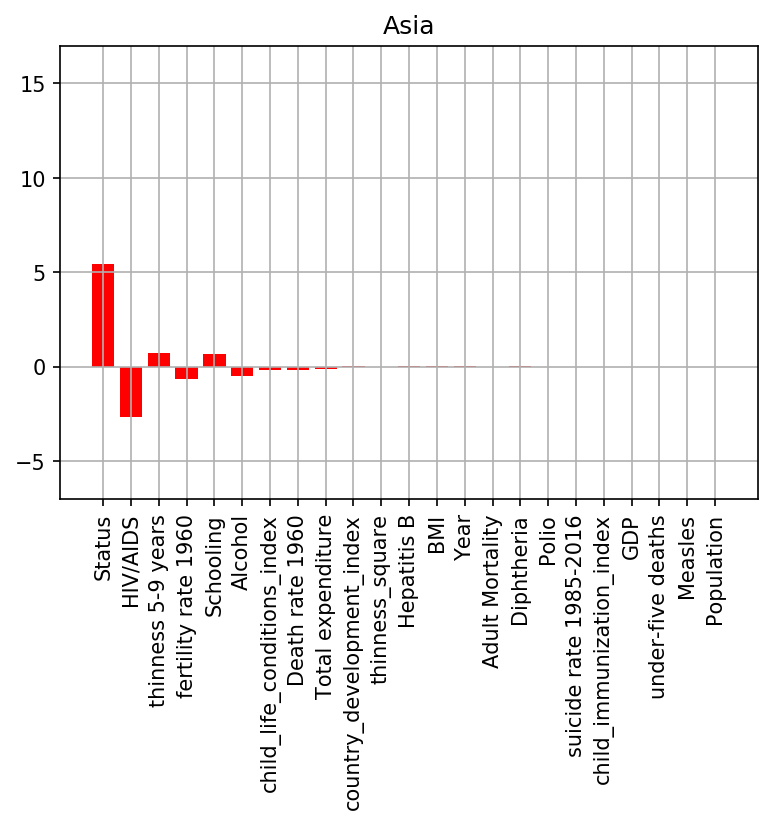

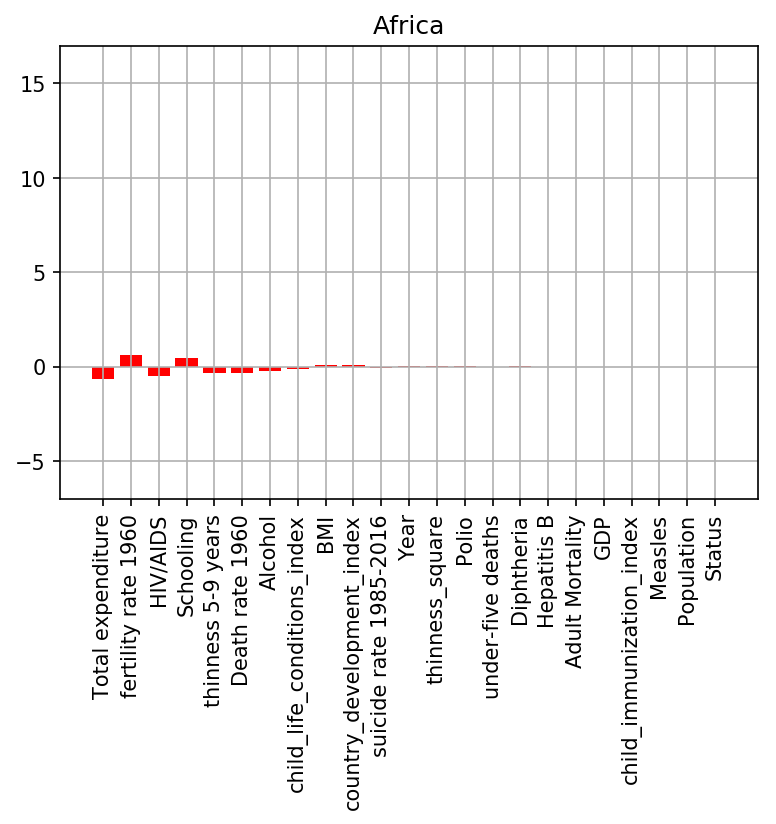

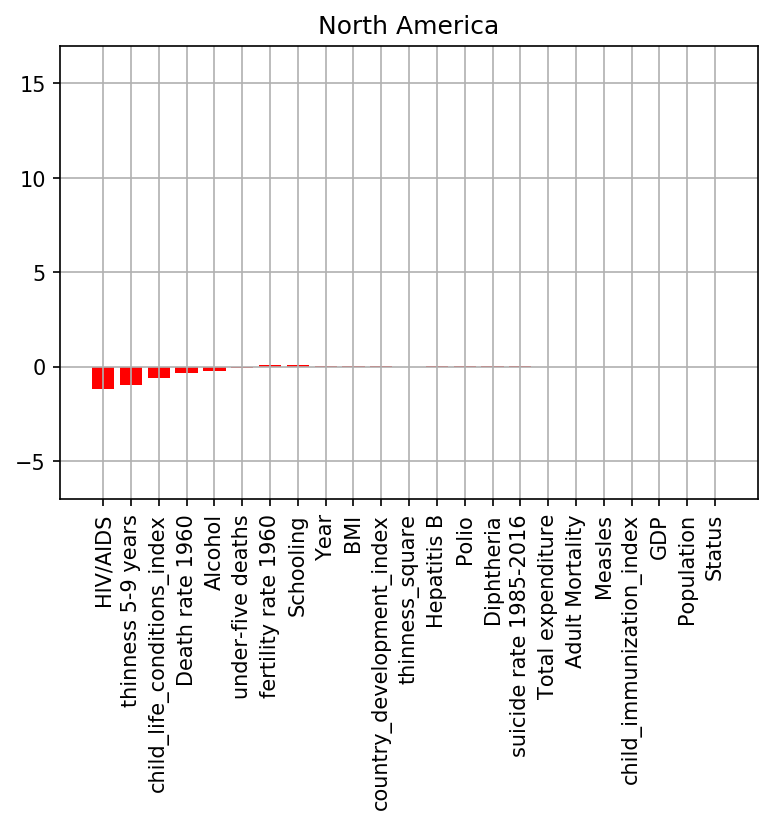

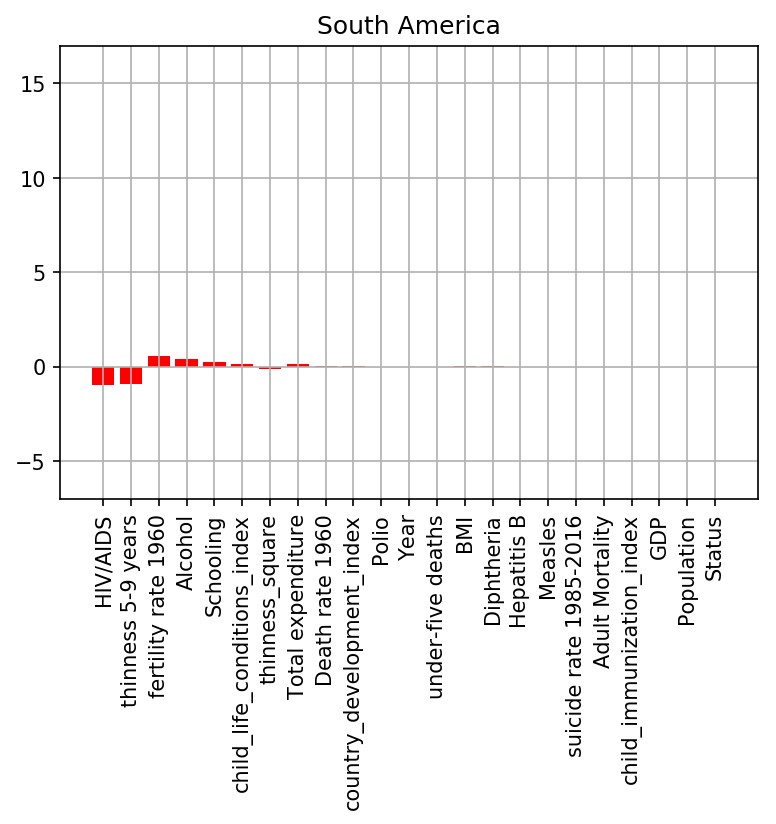

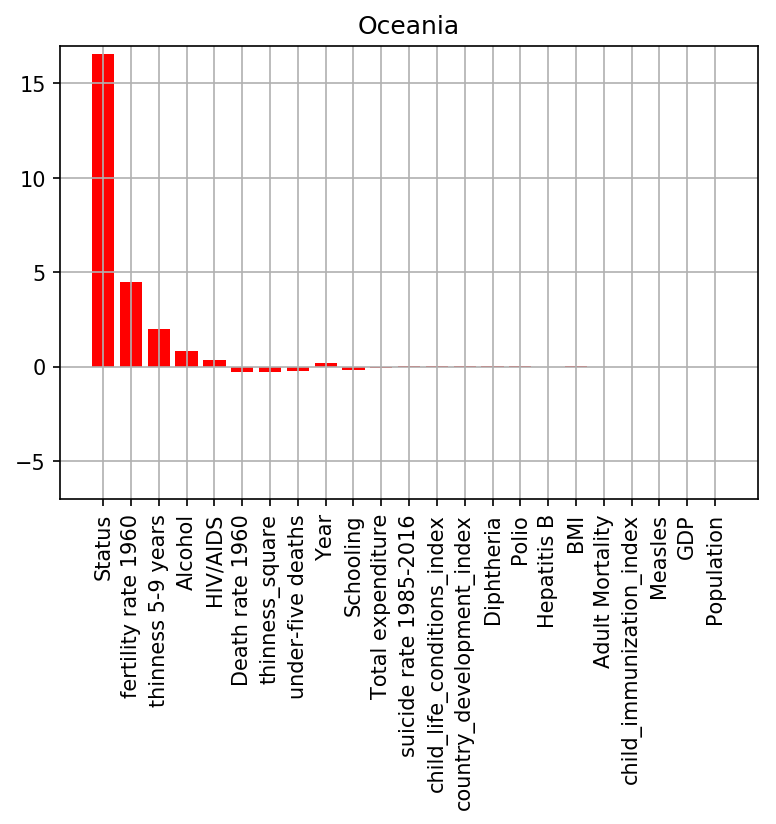

In [198]:
models = {}

for c in mapped_data.Continent.unique():
    conti_data = mapped_data.loc[mapped_data.Continent == c]
    
    X_train, X_test, y_train, y_test = train_test_split(conti_data[features], conti_data["Life expectancy"], test_size=0.2, random_state=0)  
    
    model_all = linear_model.Ridge(normalize=True)
    grid_search = GridSearchCV(model_all, param_grid=[{'alpha' : alphas}], scoring='neg_mean_squared_error', 
                                 return_train_score=True, cv=5)
    grid_search.fit(X_train, y_train)
    models[c] = grid_search.best_estimator_

    predicted_all = models[c].predict(X_test)
    
    print("{} - RMSE= {}".format(c, sqrt(mean_squared_error(y_test, predicted_all))))
    
    choose_coefs(models[c], title=c)


##### Wnioski
RMSE jest ogólnie mniejsza gdy jest liczone z rozróżnieniem na kontynenty.
Najmniejszy błąd jest dla modelu Ameryki Południowej. Prawdopodobnie wynika to z najmniejszego zróżnicowania danych dla należących do niej krajów. 
Odwrotna sytuacja jest dla Afryki (i też Ameryki Północnej) - duża liczba atrybutów ma podobny wpływ na końcowy wynik, stąd prawdopodobnie błąd jest największy.

Status kraju nie ma żadnego znaczenia dla obu Ameryk i Afryki. Dla reszty kontynentów znajduje się w ścisłej czołówce współczynników. Brak znaczenia prawdopodobnie wynika z małego zróżnicowania stopnia rozwinięcia krajów dla poszczególnych kontynentów (tzn. kontynent posiada w większości kraje rozwijające się lub kraje już rozwinięte).

Stopień umieralności dzieci spowodowany wirusem HIV ma duże znaczenie, jeśli chodzi o przewidywanie długości życia - atrybut jest w jednym z dwóch najbardziej istotnych dla każdego kontynentu.

Dla obu Ameryk i Europy istotne znaczenie ma także chudość wśród dzieci, dla reszty kontynetów - nie. Wnioskujemy, że to wynik bogactwa krajów i braku problemów z dostępnością do żywności. W Amerykach i Europie zaczyna pojawiać się problem z otyłością wśród dzieci, co wpływa na przewidywaną długość życia.


Zauważyłyśmny, że spożycie alkoholu dla większości kontynentów ma wpływ na oczekiwaną długość życia, jednakże dla niektórych krajów jest to pozytywny wpływ, a dla innych negatywny. W związku z tym ciężko nam jest zinterpretować ten wynik.

## Podsumowanie i weryfikacja hipotezy

Na podstawie wykresu współczynników dla ogólnego modelu można stwierdzić, że największy wpływ na oczekiwaną długość życia ma status kraju, w którym się żyje, poziom wykształcenia społeczeństwa oraz umieralność spowodowaną wirusem HIV. 
Okazało się, że stworzone przez nas wkaźniki mają dosyć mały wpływ na przewidywaną długość życia. Generalizują one te atrybuty, które zostały ostatecznie wybrane przez model jako te z największym znaczeniem. 
Jednakże jest zauważnalna różnica pomiędzy najistotniejszymi atrybutami dla poszczególnych kontynentów.

Wyniki naszych badań częściowo pokrywają się z naszą hipotezą postawioną w analizie eksploracyjnej. Na podstawie tego możemy sformułować tezę:

##### Największy wpływ na oczekiwaną długość życia ma status rozwinięcia kraju,  poziom wykształcenia społeczeństwa oraz umieralność spowodowaną wirusem HIV. 

## Wnioski po wprowadzeniu sugerowanych zmian

Dla każdego modelu RMSE się zmniejszył. DLa Oceanii i Ameryki Południowej wynosi poniżej 1,8. 

W ogólnym modelu dodane atrybuty nie zaburzyły wyboru głównych cech wpływających na regresje.

Dla modeli w podziale na kontynenty zauważyłyśmy:

- dzietność w 1960 roku znalazło się wśród 3 najistotniejszych cech dla Oceanii, Ameryki Południowej i Afryki,
- dla Afryki i Oceanii znaczenie HIV/AIDS się zmiejszyło,
- najbardziej zmieniły się wybrane współczynniki regularyzacji dla Oceanii (po dodaniu nowych cech),
- współczynnnik śmiertelności w 1960 roku ma wpływ dla wybranych modeli, lecz jest on niewielki,
- współczynnik średniej liczby samobójstw w latach 1985-2016 właściwie nie ma żadnego wpływu,
- dla Ameryki Północnej wzrosła istotność naszego wskaźnika warunków dziecka.

Zgodnie z sugestią wprowadziłyśmy atrybut będący kwadratem 'thinness 5-9 years', jednak nie miał on znaczego wpływu na ostateczne modele - jego udział był mniejszy niż bazowego atrybutu. Jedynie dla modelu Europy miał większe znaczenie (znalazł się na 4. miejscu).
Po dodaniu tej cechy znaczenie 'thinness 5-9 years' ogólnie wzrosło dla modeli.